# EDA and Data Preprocessing

### Importing libraries

In [17]:
import numpy as np
import pandas as pd

import dask.dataframe as dd

import matplotlib.pyplot as plt

import glob

import os
import seaborn as sns

# Read Data

In [5]:
# meta data
train = pd.read_csv("data/train.csv")
train

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
5,1640671020,22264866
6,288840453,34952168
7,1162441568,9504818
8,1791400073,11719563
9,2059516238,11629084


In [18]:
# Sort data by time to eruption
sorted_train = train.sort_values("time_to_eruption",ascending=False)
sorted_train.head()

,segment_id,time_to_eruption
1139,1923243961,49046087
3509,1552761888,48814294
3589,356854390,48727004
3739,1131527270,48522449
4132,1162128945,48387290


In [19]:
# meta data for test
test_data = pd.DataFrame([os.path.basename(f)[:-4] for f in glob.glob('data/test/*')], columns=["segment_id"])
test_data.head()

,segment_id
0,1287137774
1,1989256535
2,343649592
3,1392908532
4,1296158394


# Exploratory Data Analysis

This shows the distribution of the time to eruption which seems roughly uniform

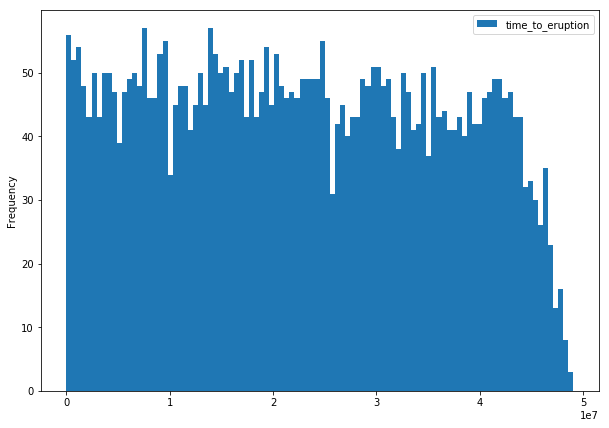

In [20]:
sorted_train[["time_to_eruption"]].plot(kind="hist",bins=100,figsize=(10,7))

This shows the max and min time to eruption from the training set

In [21]:
display(sorted_train.iloc[[0,-1],:])

max_id = 1923243961
min_id =  601524801

,segment_id,time_to_eruption
1139,1923243961,49046087
590,601524801,6250


Let's check for NaN data for the IDs with max and min time to eruption. We can see that some of the sensors are completely missed.


In [22]:
display(pd.read_csv(f"data/train/{max_id}.csv").isnull().sum())

display(pd.read_csv(f"data/train/{min_id}.csv").isnull().sum())

sensor_1     60001
sensor_2         0
sensor_3         0
sensor_4         0
sensor_5     60001
sensor_6         0
sensor_7         0
sensor_8         0
sensor_9         0
sensor_10        0
dtype: int64

sensor_1         0
sensor_2     60001
sensor_3     60001
sensor_4         0
sensor_5         0
sensor_6         0
sensor_7         0
sensor_8     60001
sensor_9         0
sensor_10      722
dtype: int64

Line plot of for a few segment_ids

In [15]:
def create_lineplot(segment_id):
    df = pd.read_csv(f"data/train/{segment_id}.csv")    
    graphs = []

    for i in range(0, 9 , 5):
        idxs = list(np.array([0, 1, 2, 3, 4]) + i)

        fig, axs = plt.subplots(1, 5, sharey=True)
        for k, item in enumerate(idxs):
            g = sns.lineplot(data=df[f"sensor_{item+1}"], ax=axs[k], color="g")
            g.set_title(f"sensor: {item+1}")
            g.set(ylim=(-10000, 10000))
            graphs.append(g)

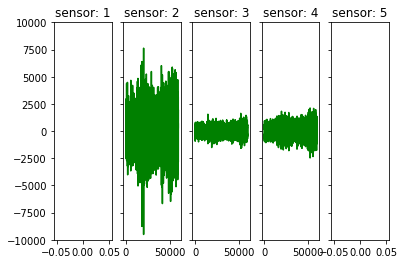

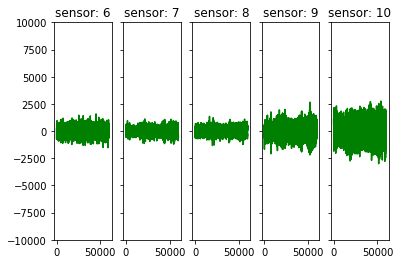

In [23]:
create_lineplot(1923243961)

Looks like sensors 1 and 5 we completely missed in this segment. Sensor 2 seems to be the one with the most fluctuations compared to the remaining sensors.

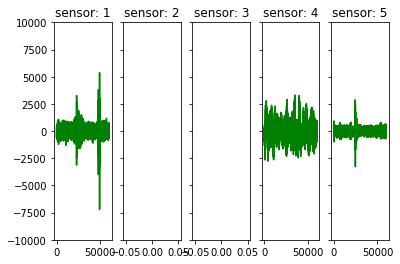

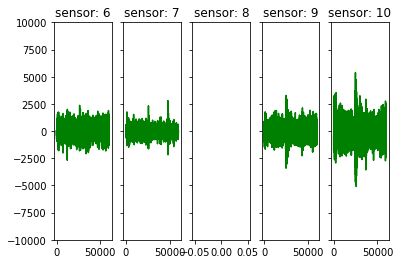

In [24]:
create_lineplot(601524801)

Looks like sensors 2,3 and 8 we completely missed in this segment. Compared to the segment with the longest time to eruption, there wasn't just a single sensor that had a wide range. We can see that sensors 1, 5 and 10 had a big fluctuation at roughly the same time. This may be an indication that these may indicate a closer time to eruption.

pair plot of each sensor data

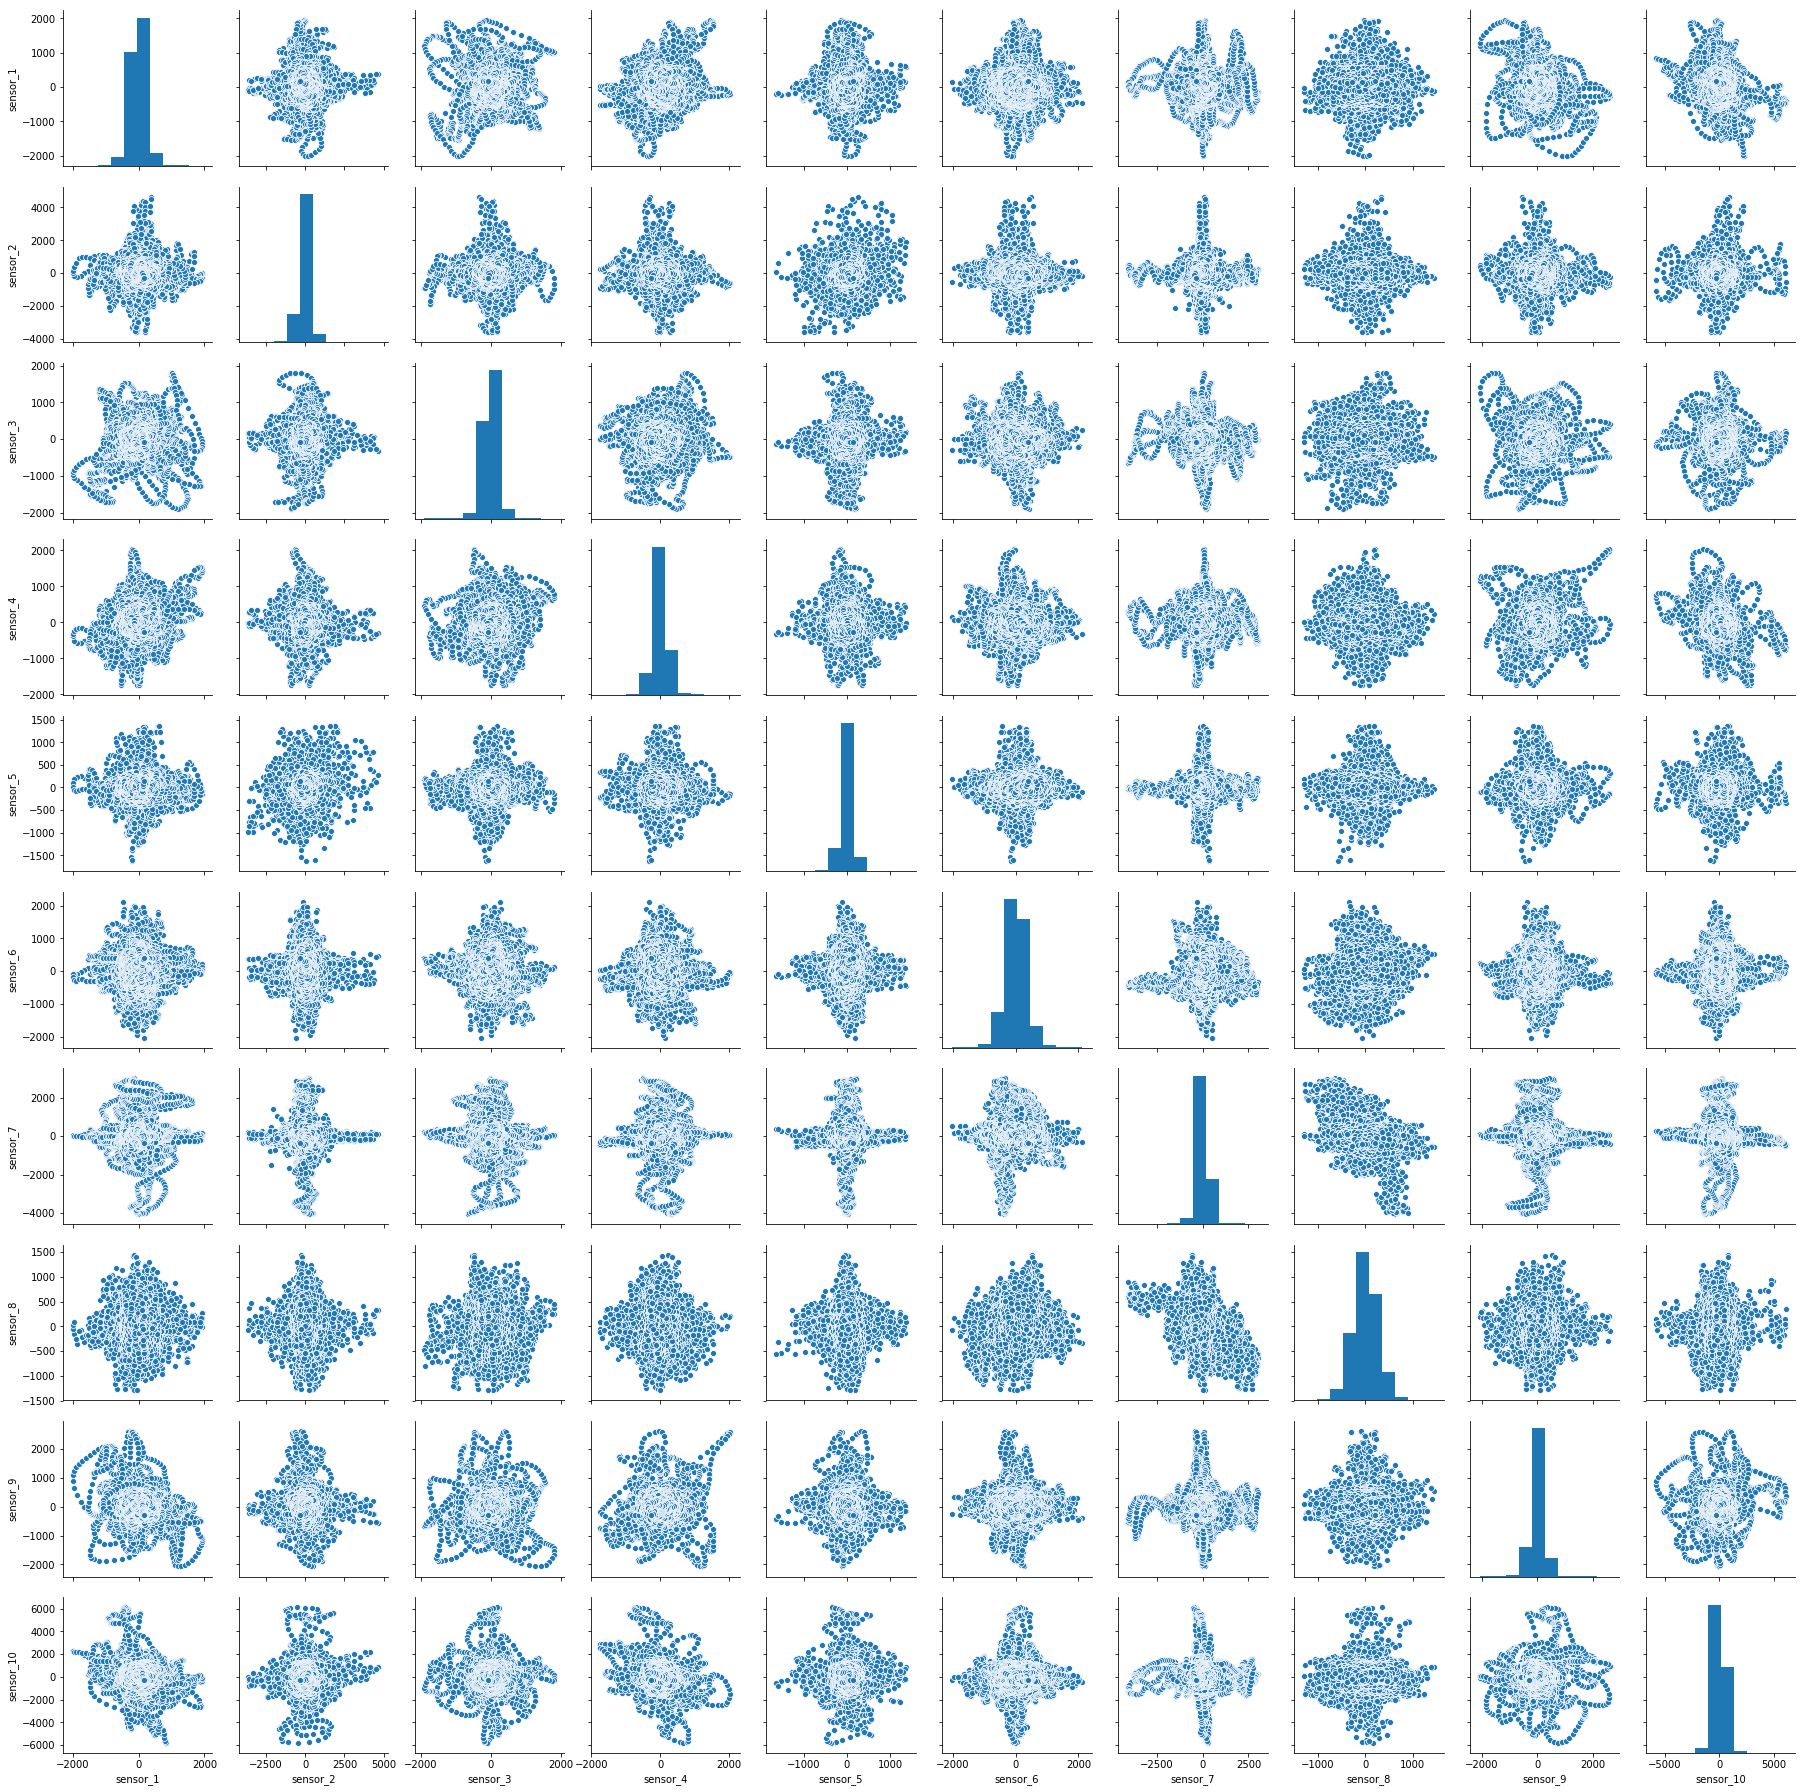

In [30]:
sns.pairplot(pd.read_csv(f"data/train/513181.csv"))

# Feature Extraction

Since the dataset contains a file per segment ID, I've created a function to extract different statistics that would be the features to be used in training the model. Included in the features are the following:
+ Mean
+ Standard Deviation
+ Maximum
+ Minimum
+ Mean Absolute Deviation
+ Skewness
+ Kurtosis
+ Median
+ Mode
+ (Unbiased) Standard Error of the Mean
+ Number of Unique Values 

Adapted from notebook

In [12]:
fs = ["_mean","_std","_max","_min","_mad","_skew","_kurt","_nunique",
      "_quantile_05","_quantile_10","_quantile_30","_quantile_70","_quantile_90","_quantile_95",
      "_fft_power_mean","_fft_power_std","_fft_power_min","_fft_power_max",
      "_fft_power_sum_low","_fft_power_sum_middle","_fft_power_sum_high",
      "_fft_power_mad","_fft_power_skew","_fft_power_kurt","_fft_power_nunique",
      "_fft_power_quantile_05","_fft_power_quantile_10","_fft_power_quantile_30","_fft_power_quantile_70",
      "_fft_power_quantile_90","_fft_power_quantile_95",
      "_cross_0_count",
      "_roll_mean_min","_roll_mean_max","_roll_dist_min","_roll_dist_max","_roll_dist_diff_min","_roll_dist_diff_max"
     ]

def extract(segment_id,dir_="train"):
    f = pd.read_csv(f"data/{dir_}/{segment_id}.csv")
    
    # Fill NaN
    f.interpolate(axis=0,inplace=True)
    
    # Quantile
    q005 = f.quantile(0.05,axis=0)
    q010 = f.quantile(0.1 ,axis=0)
    q030 = f.quantile(0.3 ,axis=0)
    q070 = f.quantile(0.7 ,axis=0)
    q090 = f.quantile(0.9 ,axis=0)
    q095 = f.quantile(0.95,axis=0)
    
    # Rolling
    roll = f.rolling(500)
    roll_mean = roll.mean()
    roll_max = roll.max()
    roll_min = roll.min()
    roll_dist = roll_max - roll_min
    roll_dist_diff = roll_dist.diff()

    # FFT power
    # Remove under flowed 0 frequency and mirrored higher half.
    fft = pd.DataFrame(np.fft.fft(f.fillna(0)),columns=f.columns).abs().iloc[1:30001,:]
    fft[f.iloc[1:30001,:].isnull()] = np.nan
        
    # Timing information inside 10 minute.
    f005 = f.where(f < q005)
    f010 = f.where(f < q010)
    f030 = f.where(f < q030)

    f070 = f.where(f > q070)
    f090 = f.where(f > q090)
    f095 = f.where(f > q095)
    
    f_abs = f.abs()
    f_abs_0250 = f_abs.where(f_abs >  250)
    f_abs_0500 = f_abs.where(f_abs >  500)
    f_abs_0750 = f_abs.where(f_abs >  750)
    f_abs_1000 = f_abs.where(f_abs > 1000)
    f_abs_1250 = f_abs.where(f_abs > 1250)
    f_abs_1500 = f_abs.where(f_abs > 1500)


    return pd.concat((f.mean(axis=0).add_suffix("_mean"),
                      f.std(axis=0).add_suffix("_std"),
                      f.max(axis=0).add_suffix("_max"),
                      f.min(axis=0).add_suffix("_min"),
                      f.mad(axis=0).add_suffix("_mad"),
                      f.skew(axis=0).add_suffix("_skew"),
                      f.kurt(axis=0).add_suffix("_kurt"),
                      f.nunique(axis=0).add_suffix("_nunique"),
                      q005.add_suffix("_quantile_05"),
                      q010.add_suffix("_quantile_10"),
                      q030.add_suffix("_quantile_30"),
                      q070.add_suffix("_quantile_70"),
                      q090.add_suffix("_quantile_90"),
                      q095.add_suffix("_quantile_95"),
                      fft.mean(axis=0).add_suffix("_fft_power_mean"),
                      fft.std(axis=0).add_suffix("_fft_power_std"),
                      fft.min(axis=0).add_suffix("_fft_power_min"),
                      fft.max(axis=0).add_suffix("_fft_power_max"),
                      fft.iloc[:10000,:].sum(axis=0).add_suffix("_fft_power_sum_low"),
                      fft.iloc[10000:20000,:].sum(axis=0).add_suffix("_fft_power_sum_middle"),
                      fft.iloc[20000:,:].sum(axis=0).add_suffix("_fft_power_sum_high"),
                      fft.mad(axis=0).add_suffix("_fft_power_mad"),
                      fft.skew(axis=0).add_suffix("_fft_power_skew"),
                      fft.kurt(axis=0).add_suffix("_fft_power_kurt"),
                      fft.nunique(axis=0).add_suffix("_fft_power_nunique"),
                      fft.quantile(0.05,axis=0).add_suffix("_fft_power_quantile_05"),
                      fft.quantile(0.1,axis=0).add_suffix("_fft_power_quantile_10"),
                      fft.quantile(0.3,axis=0).add_suffix("_fft_power_quantile_30"),
                      fft.quantile(0.7,axis=0).add_suffix("_fft_power_quantile_70"),
                      fft.quantile(0.9,axis=0).add_suffix("_fft_power_quantile_90"),
                      fft.quantile(0.95,axis=0).add_suffix("_fft_power_quantile_95"),
                      ((f * f.shift()) < 0).sum(axis=0).add_suffix("_cross_0_count"),
                      roll_mean.min(axis=0).add_suffix("_roll_mean_min"),
                      roll_mean.max(axis=0).add_suffix("_roll_mean_max"),
                      roll_dist.min(axis=0).add_suffix("_roll_dist_min"),
                      roll_dist.max(axis=0).add_suffix("_roll_dist_max"),
                      roll_dist_diff.min(axis=0).add_suffix("_roll_dist_diff_min"),
                      roll_dist_diff.max(axis=0).add_suffix("_roll_dist_diff_max"),
                      f005.idxmin().add_suffix("_first_005"),
                      f005.idxmax().add_suffix("_last_005"),
                      f010.idxmin().add_suffix("_first_010"),
                      f010.idxmax().add_suffix("_last_010"),
                      f030.idxmin().add_suffix("_first_030"),
                      f030.idxmax().add_suffix("_last_030"),
                      f070.idxmin().add_suffix("_first_070"),
                      f070.idxmax().add_suffix("_last_070"),
                      f090.idxmin().add_suffix("_first_090"),
                      f090.idxmax().add_suffix("_last_090"),
                      f095.idxmin().add_suffix("_first_095"),
                      f095.idxmax().add_suffix("_last_095"),
                      f_abs_0250.idxmin().add_suffix("_abs_0250_min"),
                      f_abs_0250.idxmax().add_suffix("_abs_0250_max"),
                      f_abs_0500.idxmin().add_suffix("_abs_0500_min"),
                      f_abs_0500.idxmax().add_suffix("_abs_0500_max"),
                      f_abs_0750.idxmin().add_suffix("_abs_0750_min"),
                      f_abs_0750.idxmax().add_suffix("_abs_0750_max"),
                      f_abs_1000.idxmin().add_suffix("_abs_1000_min"),
                      f_abs_1000.idxmax().add_suffix("_abs_1000_max"),
                      f_abs_1250.idxmin().add_suffix("_abs_1250_min"),
                      f_abs_1250.idxmax().add_suffix("_abs_1250_max"),
                      f_abs_1500.idxmin().add_suffix("_abs_1500_min"),
                      f_abs_1500.idxmax().add_suffix("_abs_1500_max"),
                     ),
                     axis=0)

Extracting the features in the train data and saving it to be loaded in SageMaker

In [14]:
#Extract features for train data

%time features = dd.from_pandas(sorted_train["segment_id"],npartitions=4).apply(extract,meta=frame).compute(scheduler="processes")

data = pd.concat((sorted_train,features),axis=1)

# Save features to resuse
data.to_csv("train_data.csv")

data

Wall time: 19min 25s


,segment_id,time_to_eruption,sensor_1_mean,sensor_2_mean,sensor_3_mean,sensor_4_mean,sensor_5_mean,sensor_6_mean,sensor_7_mean,sensor_8_mean,...,sensor_1_abs_1500_max,sensor_2_abs_1500_max,sensor_3_abs_1500_max,sensor_4_abs_1500_max,sensor_5_abs_1500_max,sensor_6_abs_1500_max,sensor_7_abs_1500_max,sensor_8_abs_1500_max,sensor_9_abs_1500_max,sensor_10_abs_1500_max
0,1136037770,12262005,-1.610323,4.613823,3.559724,2.019983,NaN,-9.718855,7.060032,1.268362,...,NaN,50607.0,NaN,16413.0,NaN,51787.0,5705.0,39659.0,43724.0,43845.0
1,1969647810,32739612,1.426126,2.484442,-2.794270,-1.700572,0.732104,-8.975067,5.870219,-1.086832,...,58311.0,15205.0,58552.0,17409.0,494.0,18153.0,18333.0,17989.0,17279.0,58131.0
2,1895879680,14965999,2.504592,5.449709,-1.588540,-1.150831,NaN,-13.328361,-1.957634,-4.111615,...,NaN,6908.0,NaN,45035.0,NaN,34602.0,50081.0,NaN,28581.0,44479.0
3,2068207140,26469720,2.165797,-0.373377,-2.698988,-1.316861,0.308795,-0.836886,-0.843136,-0.175314,...,NaN,53086.0,NaN,NaN,53292.0,57272.0,54587.0,19648.0,53769.0,54010.0
4,192955606,31072429,0.073815,NaN,1.998883,0.245079,-0.441376,2.205647,-4.784354,-1.730321,...,NaN,NaN,NaN,NaN,NaN,21552.0,NaN,13668.0,58864.0,20384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,873340274,15695097,0.906735,-3.658256,-0.751437,1.915551,-1.714721,-22.033699,1.607623,0.046333,...,34565.0,45262.0,1526.0,28470.0,1071.0,46891.0,NaN,NaN,9595.0,39475.0
4427,1297437712,35659379,7.936884,NaN,5.014233,-4.597357,NaN,0.607590,1.506825,-4.511225,...,283.0,NaN,119.0,278.0,NaN,114.0,457.0,769.0,96.0,176.0
4428,694853998,31206935,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,...,NaN,59616.0,NaN,NaN,59776.0,33034.0,15972.0,27125.0,NaN,28283.0
4429,1886987043,9598270,0.905818,NaN,-0.648256,-2.339661,0.320345,6.707488,-3.654656,NaN,...,47752.0,NaN,23345.0,23239.0,22684.0,36394.0,23909.0,NaN,22864.0,23272.0


Extracting the features in the test data and saving it to be loaded in SageMaker

In [15]:
# Extract features for test data

%time _test = dd.from_pandas(test_["segment_id"],npartitions=4).apply(extract,dir_="test",meta=frame).compute(scheduler="processes")
test = pd.concat((test_,_test),axis=1)

# Save features to reuse
test.to_csv("test_data.csv")

test

Wall time: 18min 44s


,segment_id,sensor_1_mean,sensor_2_mean,sensor_3_mean,sensor_4_mean,sensor_5_mean,sensor_6_mean,sensor_7_mean,sensor_8_mean,sensor_9_mean,...,sensor_1_abs_1500_max,sensor_2_abs_1500_max,sensor_3_abs_1500_max,sensor_4_abs_1500_max,sensor_5_abs_1500_max,sensor_6_abs_1500_max,sensor_7_abs_1500_max,sensor_8_abs_1500_max,sensor_9_abs_1500_max,sensor_10_abs_1500_max
0,1000213997,4.462476,NaN,3.584690,-3.677255,0.932501,-0.119815,-0.801103,-0.580557,-2.540874,...,NaN,NaN,19453.0,20332.0,NaN,8178.0,59843.0,34814.0,38253.0,NaN
1,100023368,0.838103,NaN,1.009217,-0.757037,0.340894,1.764721,-8.099515,1.104198,2.450759,...,NaN,NaN,NaN,NaN,NaN,59753.0,57627.0,58366.0,NaN,14582.0
2,1000488999,0.794903,-4.740871,2.116098,-0.380610,NaN,12.569107,1.533874,2.943134,-0.932868,...,21910.0,43407.0,NaN,NaN,NaN,15508.0,NaN,NaN,NaN,NaN
3,1001028887,1.953717,NaN,0.404360,-0.522891,-3.765535,-1.218796,-1.544341,1.841369,0.783520,...,NaN,NaN,NaN,NaN,NaN,40007.0,24916.0,18768.0,NaN,NaN
4,1001857862,-3.984584,-3.306728,0.898585,-2.389910,-0.001767,2.661156,0.937434,1.873502,3.618723,...,NaN,50019.0,NaN,50572.0,NaN,43022.0,32276.0,49597.0,NaN,50793.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,996704281,-135.674672,-999.268329,-72.957951,-624.627090,NaN,-198.286962,-96.878002,-230.499275,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
4516,997630809,-2.666439,1.447959,-2.014883,0.893418,NaN,3.223130,0.324595,7.570357,0.111981,...,NaN,39605.0,NaN,26449.0,NaN,30740.0,38759.0,52763.0,25982.0,40151.0
4517,998072137,1.192280,-0.885119,4.310145,0.304878,NaN,14.487142,-1.014200,-0.774304,NaN,...,58847.0,59907.0,NaN,NaN,NaN,33817.0,9937.0,16761.0,NaN,NaN
4518,998136924,3.218563,-0.552941,-2.343444,-2.133098,0.155914,-0.957801,-1.103298,-2.347594,2.642623,...,NaN,2706.0,23550.0,NaN,23450.0,10867.0,5787.0,13335.0,NaN,23616.0
